In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy as copy
import torch.optim as optim
import random
import re
import os
import jieba
from tqdm import tqdm
from tqdm import trange
def seed_torch(seed=1122):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
BERT_PATH = 'bert-base-chinese/'

In [2]:
class GetBERT(nn.Module):

    def __init__(self):
        super(GetBERT, self).__init__()
        self.bert_tokenizer = BertTokenizer.from_pretrained("chinese-bert-wwm-ext")
        self.bert = BertModel.from_pretrained("chinese-bert-wwm-ext")
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, sentence_lists):
        """
        输入句子列表(去掉了停用词的)
        """
        sentence_lists = [' '.join(x) for x in sentence_lists]
        # print('sentence_lists:'+str(sentence_lists))
        ids = self.bert_tokenizer(sentence_lists, padding=True, return_tensors="pt")
        # print('ids:'+str(ids))
        inputs = ids['input_ids']
        # print('inputs:'+str(inputs))

        embeddings = self.bert(inputs)
        # print(str(embeddings[0].shape))
        x = embeddings[0]  # 1 * 768
        # print(x.shape)
        return x


In [3]:
class Pre:
    def __init__(self, text):
        """
        输入一个文本
        """
        self.puncs_coarse = ['。', '!', '；', '？', '……', '\n', ' ']
        self.text = text
        self.stopwords = self.deal_wrap('dict/stop1205.txt')

    def segment(self, sentence):
        sentence_seged = jieba.cut(sentence.strip())
        outstr = ''
        for word in sentence_seged:
            if word not in self.stopwords:
                if word != '\t':
                    outstr += word
                    outstr += " "
        word_list = outstr.split(' ')
        pattern = '[A-Za-z]*[0-9]*[\'\"\%.\s\@\!\#\$\^\&\*\(\)\-\<\>\?\/\,\~\`\:\;]*[：；”“ ‘’+-——！，。？、~@#￥%……&*（）【】]*'
        t = [re.sub(pattern, "", x.strip()) for x in word_list]
        t = [x for x in t if x != '']
        return ''.join(t)

    def deal_wrap(self, filedict):
        temp = []
        for x in open(filedict, 'r', encoding='utf-8').readlines():
            temp.append(x.strip())
        return temp

    def split_sentence_coarse(self):
        """
        按照。！？“”等中文完整句子语义来分句
        1. 去除换行符、多余的空格、百分号
        2. 分句，存入列表
        :return:装着每个句子的列表（包括标点符号）
        """

        text = self.text
        sentences = []
        start = 0
        for i in range(len(text)):
            if text[i] in self.puncs_coarse:
                sentences.append(text[start:i + 1])
                start = i + 1
        if start == 0:
            sentences.append(text)
        return sentences

    def get_keywords(self, data):
        """
        如果句子太长，就进行关键词提取
        """
        from jieba import analyse
        textrank = analyse.textrank
        keywords = textrank(data, topK=8)
        return ''.join(keywords)

    def preprocess(self):
        # 分句
        sentences = self.split_sentence_coarse()
        # 对每个句子，去除里面的停用词，再连起来
        # 对每个句子，如果句子太长，长度大于20（我随便定的），就抽取八个关键词连起来
        new_sent = []
        for i in sentences:
            if len(i) < 5:
                new_sent.append(i)
                continue
            i = self.segment(i)
            if len(i) > 25:
                i = self.get_keywords(i)
            if i != '':
                new_sent.append(i)
        return new_sent

In [4]:
class GetData():
    def __init__(self, pos=5000, neg=4600):
        data = pd.read_csv('sentiment_classify_data/raw_comment_v2.csv')
        data = data[data['score'] != 3].reset_index()
        data['label'] = data['score'].map(lambda a: 1 if a in [4, 5] else 0)
        data.drop(['post_time','score','shop_url'],inplace=True,axis=1)
        
#         data = pd.read_excel('sentiment_classify_data/comments_raw_v1.xls')
#         data = data[data['score'] != 3].reset_index()
#         data['label'] = data['score'].map(lambda a: 1 if a in [4, 5] else 0)
#         data.drop(['id', 'score'], inplace=True, axis=1)
        
        data['content'] = [str(i) for i in list(data['content'])]
        # 原数据标签为0（负向情感）的数据有3632条，正向情感的有57262条
        data1 = data[data['label'] == 1].sample(pos)
        data0 = data[data['label'] == 0].sample(neg)
        data = pd.concat([data1, data0], axis=0, ignore_index=True)
        self.data = data

    def split_sen(self):
        x = []
        y = []
        for i in range(len(self.data)):
            p = Pre(self.data['content'][i])
            sen_lst = p.preprocess()
            if sen_lst == []:
                continue
            x.append(sen_lst)
            y.append(self.data['label'][i])
        print(len(x))
        print(y.count(1))
        print(y.count(0))
        return x, y


In [5]:
class LSTM(nn.Module):

    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm_layer = nn.LSTM(input_size=768, hidden_size=128, batch_first=True)
        self.linear_layer = nn.Linear(in_features=128, out_features=2, bias=True)

    def forward(self, x):
        out1, (h_n, h_c) = self.lstm_layer(x)
        a, b, c = h_n.shape
        out = self.linear_layer(h_n.reshape(a * b, c))
        out = F.log_softmax(out, dim=1)
        return out

In [6]:
def train_model(epoch, train_dataLoader, test_dataLoader):
    # 训练模型
    best_model = None
    train_loss = 0
    test_loss = 0
    best_loss = 100
    epoch_cnt = 0
    for _ in range(epoch):
        total_train_loss = 0
        total_train_num = 0
        total_test_loss = 0
        total_test_num = 0
        for x, y in tqdm(train_dataLoader,
                         desc='Epoch: {}| Train Loss: {}| Test Loss: {}'.format(_, train_loss, test_loss)):
        #for x, y in train_dataLoader:
            x_num = len(x)
            p = model(x)
            loss = loss_func(p, y.long())
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            total_train_loss += loss.item()
            total_train_num += x_num
        train_loss = total_train_loss / total_train_num
        train_loss_list.append(train_loss)
        for x, y in test_dataLoader:
            x_num = len(x)
            p = model(x)
            loss = loss_func(p, y.long())
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            total_test_loss += loss.item()
            total_test_num += x_num
        test_loss = total_test_loss / total_test_num
        test_loss_list.append(test_loss)
        
        # early stop
        if best_loss > test_loss:
            best_loss = test_loss
            best_model = copy(model)
            torch.save(best_model.state_dict(), 'lstm_.pth')
            epoch_cnt = 0
        else:
            epoch_cnt += 1
            
        if epoch_cnt > early_stop:
            torch.save(best_model.state_dict(), 'lstm_.pth')
            print("保存模型")
            #print(best_model.state_dict())
            break

In [7]:
def test_model(test_dataLoader_):
    pred = []
    label = []
    model_.load_state_dict(torch.load("lstm_.pth"))
    model_.eval()
    total_test_loss = 0
    total_test_num = 0
    for x, y in test_dataLoader_:
        x_num = len(x)
        p = model_(x)
        #         print('##', len(p), len(y))
        loss = loss_func(p, y.long())
        total_test_loss += loss.item()
        total_test_num += x_num
        pred.extend(p.data.squeeze(1).tolist())
        label.extend(y.tolist())
    test_loss = total_test_loss / total_test_num
    # print('##', len(pred), len(label))
    return pred, label, test_loss, test_loss_list

In [23]:
seed_torch(22)
epoch = 10
batch_size = 20
early_stop = 5
test_loss_list = []
train_loss_list = []

# 初始化模型
model = LSTM()
model_ = LSTM()

# 数据处理部分
gd = GetData()
x, y = gd.split_sen()
pos = y.count(1)
neg = y.count(0)
pos_train = int(pos*0.9)
neg_train = int(neg*0.9)
x1 = x[:pos]  # 3988   --- 3589train 399test
y1 = y[:pos]
x0 = x[pos:]  # 3589   ---- 3230train 359test
y0 = y[pos:]

train_x = x0[:neg_train] + x1[:pos_train]
train_y = y0[:neg_train] + y1[:pos_train]
print("训练集有"+str(len(train_x))+"个数据")

# c = list(zip(train_x, train_y))
# random.shuffle(c)
# c = random.sample(c, 50)
# train_x[:], train_y[:] = zip(*c)

test_x = x0[neg_train:] + x1[pos_train:]
test_y = y0[neg_train:] + y1[pos_train:]
print("测试集有"+str(len(test_x))+"个数据")

bert = GetBERT()
x_train = bert(train_x)
x_test = bert(test_x)
y_train = torch.tensor(train_y).float()
y_test = torch.tensor(test_y).float()
train_data = TensorDataset(x_train, y_train)
train_dataLoader = DataLoader(train_data, batch_size=batch_size)
test_data = TensorDataset(x_test, y_test)
test_dataLoader = DataLoader(test_data, batch_size=batch_size)

# 损失函数和优化器
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(epoch, train_dataLoader, test_dataLoader)
p, y, test_loss, test_loss_list = test_model(test_dataLoader)
ans = []
for t in p:
    if t[0]>t[1]:
        ans.append(0)
    else:
        ans.append(1)
print(accuracy_score(ans,y))

9574
4988
4586
训练集有8616个数据
测试集有958个数据


Epoch: 0| Train Loss: 0| Test Loss: 0: 100%|██████████| 431/431 [01:33<00:00,  4.59it/s]
Epoch: 1| Train Loss: 0.008397677536919208| Test Loss: 0.09006156385069351: 100%|██████████| 431/431 [01:30<00:00,  4.75it/s]
Epoch: 2| Train Loss: 0.018091594061434627| Test Loss: 0.07377149405770611: 100%|██████████| 431/431 [01:31<00:00,  4.69it/s]
Epoch: 3| Train Loss: 0.020521014404786663| Test Loss: 0.06546261002910411: 100%|██████████| 431/431 [01:34<00:00,  4.55it/s]
Epoch: 4| Train Loss: 0.020582437517853002| Test Loss: 0.06717363057467535: 100%|██████████| 431/431 [01:31<00:00,  4.70it/s]
Epoch: 5| Train Loss: 0.021161091505716743| Test Loss: 0.06410236625556906: 100%|██████████| 431/431 [01:32<00:00,  4.67it/s]
Epoch: 6| Train Loss: 0.02217739091679357| Test Loss: 0.06274305691549822: 100%|██████████| 431/431 [01:32<00:00,  4.65it/s]
Epoch: 7| Train Loss: 0.02250584140558318| Test Loss: 0.062374300212601284: 100%|██████████| 431/431 [01:26<00:00,  4.97it/s]
Epoch: 8| Train Loss: 0.022654

0.5271398747390397


In [11]:
print(torch.cuda.device_count())   # --> 0
print(torch.cuda.is_available())   # --> False
print(torch.version.cuda)          # --> 9.0.176

0
False
10.1


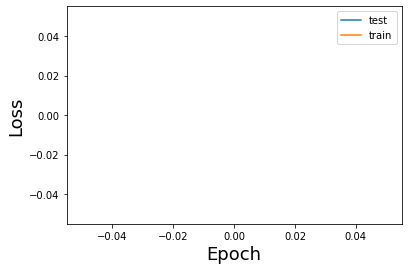

In [28]:
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.plot(test_loss_list)
plt.plot(train_loss_list)
plt.legend(["test","train"])

In [8]:
class LSTM2(nn.Module):

    def __init__(self):
        super(LSTM2, self).__init__()
        self.lstm_layer = nn.LSTM(input_size=768, hidden_size=512, batch_first=True)
        self.linear_layer = nn.Linear(in_features=512, out_features=256, bias=True)
        self.linear_layer2 = nn.Linear(in_features=256, out_features=2, bias=True)

    def forward(self, x):
        out1, (h_n, h_c) = self.lstm_layer(x)
        a, b, c = h_n.shape
        out = self.linear_layer(h_n.reshape(a * b, c))
        out = self.linear_layer2(out)
        out = F.log_softmax(out, dim=1)
        return out

In [9]:
seed_torch(22)
epoch = 10
batch_size = 20
early_stop = 5
test_loss_list = []
train_loss_list = []

# 初始化模型
model = LSTM2()
model_ = LSTM2()

# 数据处理部分
gd = GetData()
x, y = gd.split_sen()
pos = y.count(1)
neg = y.count(0)
pos_train = int(pos*0.9)
neg_train = int(neg*0.9)
x1 = x[:pos]  # 3988   --- 3589train 399test
y1 = y[:pos]
x0 = x[pos:]  # 3589   ---- 3230train 359test
y0 = y[pos:]

train_x = x0[:neg_train] + x1[:pos_train]
train_y = y0[:neg_train] + y1[:pos_train]
print("训练集有"+str(len(train_x))+"个数据")

# c = list(zip(train_x, train_y))
# random.shuffle(c)
# c = random.sample(c, 50)
# train_x[:], train_y[:] = zip(*c)

test_x = x0[neg_train:] + x1[pos_train:]
test_y = y0[neg_train:] + y1[pos_train:]
print("测试集有"+str(len(test_x))+"个数据")

bert = GetBERT()
x_train = bert(train_x)
x_test = bert(test_x)
y_train = torch.tensor(train_y).float()
y_test = torch.tensor(test_y).float()
train_data = TensorDataset(x_train, y_train)
train_dataLoader = DataLoader(train_data, batch_size=batch_size)
test_data = TensorDataset(x_test, y_test)
test_dataLoader = DataLoader(test_data, batch_size=batch_size)

# 损失函数和优化器
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(epoch, train_dataLoader, test_dataLoader)
p, y, test_loss, test_loss_list = test_model(test_dataLoader)
ans = []
for t in p:
    if t[0]>t[1]:
        ans.append(0)
    else:
        ans.append(1)
print(accuracy_score(ans,y))

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.674 seconds.
Prefix dict has been built successfully.


9574
4988
4586
训练集有8616个数据
测试集有958个数据


Epoch: 0| Train Loss: 0| Test Loss: 0:   0%|          | 0/431 [00:00<?, ?it/s]/app/common/miniconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
Epoch: 0| Train Loss: 0| Test Loss: 0: 100%|██████████| 431/431 [02:38<00:00,  2.72it/s]
Epoch: 1| Train Loss: 0.007235404177817001| Test Loss: 0.16754387196684686: 100%|██████████| 431/431 [04:02<00:00,  1.78it/s]
Epoch: 2| Train Loss: 0.02632076990841716| Test Loss: 0.15709324616277007: 100%|██████████| 431/431 [03:36<00:00,  1.99it/s]
Epoch: 3| Train Loss: 0.012746736046362363| Test Loss: 0.1280096331413239: 100%|██████████| 431/431 [03:16<00:00,  2.19it/s]
Epoch: 4| Train Loss: 0.012353127845964153| Test Loss: 0.11382797186532782: 100

0.5208768267223383


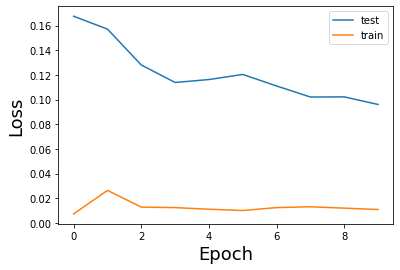

In [10]:
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.plot(test_loss_list)
plt.plot(train_loss_list)
plt.legend(["test","train"])

# 双向GRU

In [11]:
class BiGRU(torch.nn.Module):
    def __init__(self, input_dim=768,hidden_size=768, out_size=2, n_layers=1, batch_size=1):
        super(BiGRU, self).__init__()

        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.out_size = out_size
        self.gru = torch.nn.GRU(input_dim, hidden_size, n_layers, batch_first=True,bidirectional=True)
        self.fc1 = torch.nn.Linear(hidden_size*2, 300)
        self.fc2 = torch.nn.Linear(300, out_size)
        
    def forward(self, word_inputs, hidden):
       # hidden 就是上下文输出，output 就是 RNN 输出
        output, hidden = self.gru(word_inputs, hidden)
        # output是所有隐藏层的状态，hidden是最后一层隐藏层的状态
        output = self.fc1(output)
        output = self.fc2(output)

        # 仅仅获取 time seq 维度中的最后一个向量
        # the last of time_seq
        output = output[:,-1,:]
        out = F.log_softmax(out, dim=1)

        return out

    def init_hidden(self):
        hidden = torch.autograd.Variable(torch.zeros(2*self.n_layers, self.batch_size, self.hidden_size, device='cuda'))
        return hidden

In [13]:
seed_torch(22)
epoch = 10
batch_size = 20
early_stop = 5
test_loss_list = []
train_loss_list = []

# 初始化模型
model = BiGRU()
model_ = BiGRU()

# 数据处理部分
gd = GetData(pos=10, neg=10)
x, y = gd.split_sen()
pos = y.count(1)
neg = y.count(0)
pos_train = int(pos*0.9)
neg_train = int(neg*0.9)
x1 = x[:pos]  # 3988   --- 3589train 399test
y1 = y[:pos]
x0 = x[pos:]  # 3589   ---- 3230train 359test
y0 = y[pos:]

train_x = x0[:neg_train] + x1[:pos_train]
train_y = y0[:neg_train] + y1[:pos_train]
print("训练集有"+str(len(train_x))+"个数据")

# c = list(zip(train_x, train_y))
# random.shuffle(c)
# c = random.sample(c, 50)
# train_x[:], train_y[:] = zip(*c)

test_x = x0[neg_train:] + x1[pos_train:]
test_y = y0[neg_train:] + y1[pos_train:]
print("测试集有"+str(len(test_x))+"个数据")

bert = GetBERT()
x_train = bert(train_x)
x_test = bert(test_x)
y_train = torch.tensor(train_y).float()
y_test = torch.tensor(test_y).float()
train_data = TensorDataset(x_train, y_train)
train_dataLoader = DataLoader(train_data, batch_size=batch_size)
test_data = TensorDataset(x_test, y_test)
test_dataLoader = DataLoader(test_data, batch_size=batch_size)

# 损失函数和优化器
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(epoch, train_dataLoader, test_dataLoader)
p, y, test_loss, test_loss_list = test_model(test_dataLoader)
ans = []
for t in p:
    if t[0]>t[1]:
        ans.append(0)
    else:
        ans.append(1)
print(accuracy_score(ans,y))

20
10
10
训练集有18个数据
测试集有2个数据


Epoch: 0| Train Loss: 0| Test Loss: 0:   0%|          | 0/1 [00:00<?, ?it/s]


TypeError: forward() missing 1 required positional argument: 'hidden'